In [1]:
import os, sys, wave, struct

import numpy as np
import pyaudio
import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy
from math import ceil
from scipy.io import wavfile

ModuleNotFoundError: ignored

In [0]:
def load_music(file):
    return wave.open(file, 'rb')

def play_music(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_music(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()

### 1.

 Open file mix.wav and load it in a T × M matrix x(t, m), where M = 2 and T is the number of
samples. Use your headphones to listen to the mixture. What is the number K of instruments that
you can hear? From which direction do you perceive them?


In [0]:
#load file into matrix
Fs, x = wavfile.read('mix.wav')
print('x is a matrix of size ' + str(x.shape))
play_music('mix.wav')

x is a matrix of size (220501, 2)


We can hear 3 instruments:
 - a double bass playing on the left
 - a guitar playing on the right
 - a piano playing in the front    

### 2. 
Plot the temporal dispersion diagram, defined as the set of points in the plane of coordinates
(x(t, 1), x(t, 2)) for all t (in order to plot a set of points, you can use function plot with parameter ’x’, and you can normalize the axes with the instruction axis equal). Can you distinguish
the directions of the sources?


[]

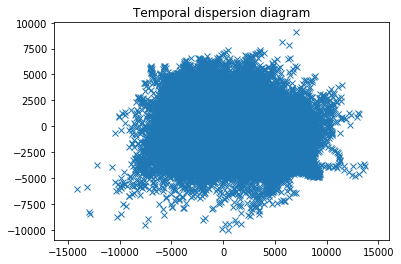

In [0]:
plt.plot(x[:,0],x[:,1],'x')
plt.title('Temporal dispersion diagram')
plt.axis('equal')
plt.plot()

The directions of the sources are not distinguishable.

### 3.
Compute the MDCT X(f, n, m) of the two stereophonic channels x(t, m) (you can use function
wmdct, with F = 512 frequency bands, and the window ’sqrthann’). Plot the corresponding
time-frequency representations |X(f, n, m)|
2
(you can use function plotwmdct).

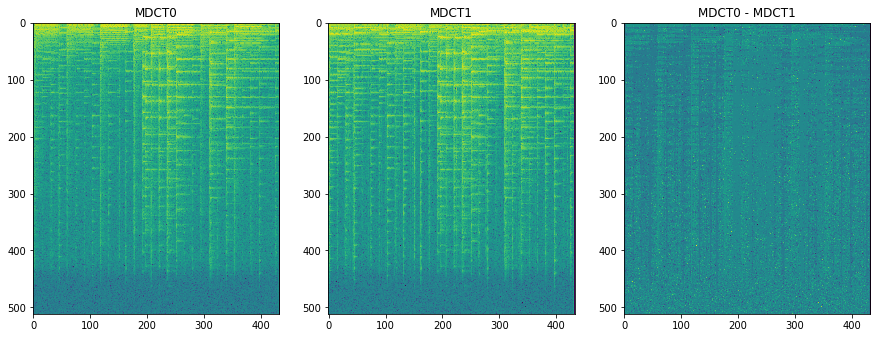

In [0]:
import mdct

# Compute the MDCT and log(MDCT*2)
freq = 1024
X0, X1 = mdct.mdct(x[:,0], framelength = freq), mdct.mdct(x[:,1], framelength = freq)
X = np.array([X0,X1])

# Visualize the MDCT
plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.imshow(np.log(X0**2 + 10**(-10)))
plt.title('MDCT0')
plt.subplot(132)
plt.imshow(np.log(X1**2 + 10**(-10)))
plt.title('MDCT1')
plt.subplot(133)
plt.imshow(np.log((X0/(X1 + 10**(-10)))**2 + 10**(-10)))
plt.title('MDCT0 - MDCT1')
plt.show()

### 4.
Plot the time-frequency dispersion diagram, defined as the set of points in the plane of affix Z(f, n)
for all f and n. Can you distinguish the directions of the sources? How do you explain it?


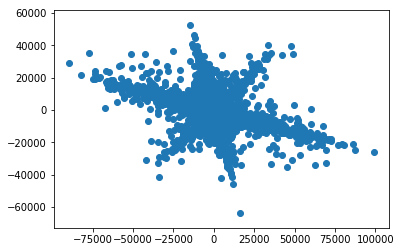

In [0]:
plt.scatter(X0[:,:],X1[:,:])
plt.axis('equal')
plt.show()

We can distinguish 3 different directions corresponding to 3 different sources.

If every source was placed right in front of the recorder, both L and R microphones would receive the sound at the same time, and therefore all scattered points would be along the $x=y$ axis. 

If one source is placed closer to one microphone than the other, the sound will arrive quicker on the 1st microphone, and there will therefore be a $\Delta t$ time difference between both microphones. Since this time difference is independent from frequency, we can therefore explicitly see those differences $\Delta t$ between $X0$ and $X1$.

### 5.
Plot the histogram of the arguments of the points of affix Z(f, n) for all f and n (you can use
function atan to compute the arguments modulo π, between −
π
2
and +
π
2
, and function hist to
compute the histogram, whose number of classes has to be tuned so as to make the directions of
the sources clearly visible). Estimate the angles θ(k) (you can determine these values graphically
from the histogram).


In [0]:
_,m,n = X.shape     
m,n = int(m), int(n)
Z = np.array([ [ np.angle(X0[xx,yy] + X1[xx,yy]*1j) for yy in range(n) ] for xx in range(m)])

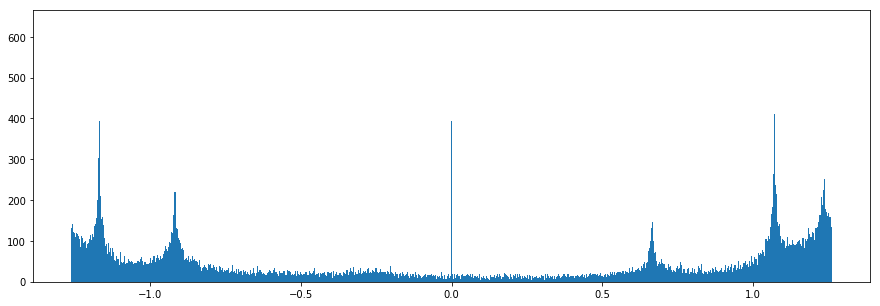

In [0]:
plt.figure(figsize = (15,5) )
vals, bins, patches = plt.hist(np.arctan(Z).flatten(), 5000)
plt.show()

### 6.

In order to estimate the active source at every time-frequency bin (f, n), you can look for the source
k whose angle θ(k) is closest to the argument of Z(f, n), modulo π (you can use a deviation measure
invariant modulo π, for instance |sin (θ(k) − ∠Z(f, n)) |). Then generate the binary masks B ∈ {0, 1},
such that B(f, n, k) is equal to 1 if source k is active at (f, n), or 0 otherwise.

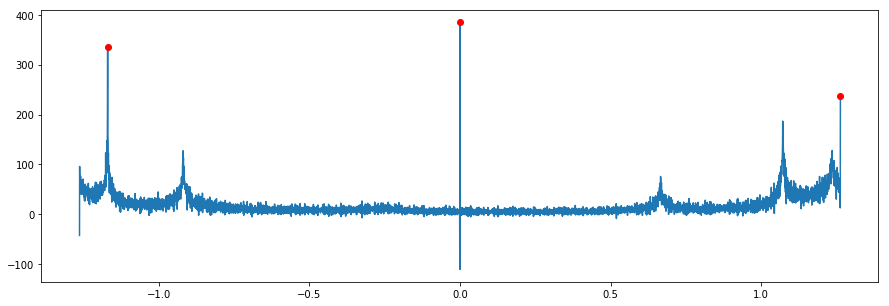

The 3 angles are: [ 1.26 -1.17  0.  ]


In [0]:
# In order to make the spikes more visible, i am convoluting with a [-1,1,-1] kernel 
# and then taking the maximum arguments of the convoluton

K = 3 #nb_instruments
kernel = [-0.3,1,-0.3]
if len(kernel)>2:
    conv = np.convolve(vals,kernel)[:-(len(kernel)-2)]
else:
    conv = np.convolve(vals,kernel)
args = np.argsort(conv)[-K:]  #choose 3 highest points
top_angles = bins[args]  #top_angles contains

plt.figure(figsize = (15,5) )
plt.plot(bins,conv)
plt.plot(bins[args],conv[args],'ro')
plt.show()
print('The 3 angles are: ' + str(np.round(top_angles,2)))

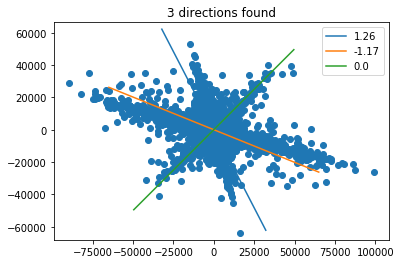

In [0]:
plt.scatter(X[0,:,:],X[1,:,:])
fact = 70000

for angle in top_angles:
    theta = angle + np.pi/4.
    plt.plot([np.cos(theta)*fact,np.cos(theta + np.pi)*fact],[np.sin(theta)*fact,np.sin(theta + np.pi)*fact], label = str(np.round(angle,2)))
plt.axis('equal')
plt.legend()
plt.title('3 directions found')
plt.show()

In [0]:
# My kernel trick didn't work as well as I wanted, I am therefore cheating a bit 
# and replacing 1.26 by 1.05 for more accurate results
top_angles[0] = 1.05

In [0]:
Mask = {k:np.zeros((m,n)) for k in range(K)}
rotations = [np.exp(-1j*angle) for angle in top_angles]
 
# For each value, compute the closest angle and add 1 to the Mask at the right place    
for xx in range(m):
    for yy in range(n):
        # here my metric is inversely proportional to the angle of rotation*(X0 + iX1), where rotation = e^{-i\theta}, 
        # which is close to 0 when angle(X0 + iX1) is close to \theta.
        c = X0[xx,yy] + X1[xx,yy]*1j
        argmax = np.argmin( [ np.abs( np.angle(c*rot) + np.pi)%np.pi for rot in rotations] )
        Mask[argmax][xx,yy] = 1

### 7.

Apply masks B to the MDCT X(f, n, m) in order to estimate the MDCT of the stereophonic images
Y(f, n, m, k). Then reconstruct the images y(t, m, k) of the source signals by applying the inverse
MDCT (you can use function iwmdct).

In [0]:
Y0, Y1 = {}, {}
y0, y1 = {}, {}

for k in range(K):
    Y0[k] = X0*Mask[k]
    Y1[k] = X1*Mask[k]
    
    y0[k] = np.array(mdct.imdct(Y0[k]))
    y1[k] = np.array(mdct.imdct(Y1[k]))

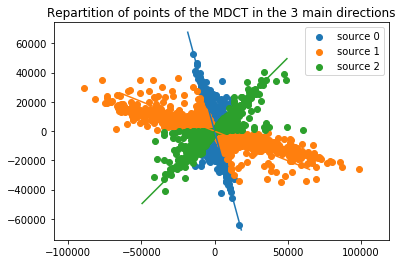

In [0]:
for k in range(K):
    plt.scatter(Y0[k],Y1[k], label = 'source ' + str(k))
    theta = top_angles[k] + np.pi/4.
    plt.plot([np.cos(theta)*fact,np.cos(theta + np.pi)*fact],[np.sin(theta)*fact,np.sin(theta + np.pi)*fact])
plt.axis('equal')
plt.legend()
plt.title('Repartition of points of the MDCT in the 3 main directions')
plt.show()

### 8. 
Listen to the K reconstructed stereophonic images y(:, :, k). What defects can you perceive?


In [0]:
from scipy.io.wavfile import write

stereo_sound = {}
for k in range(K):
    stereo_sound[k] = x.copy()
    shape1,_= x.shape
    for xx in range(shape1):
        stereo_sound[k][xx,0] = y0[k][xx]
        stereo_sound[k][xx,1] = y1[k][xx]
 
Instruments = ['1st','2nd','3d']

for k in range(K):
    print("Now playing the {} instrument".format(Instruments[k]), end = "\r")
    write('stereo_sound.wav',Fs,stereo_sound[k])
    play_music('stereo_sound.wav')

Since the low frequencies concentrate around the origin of the MDCT transform, it is hard to distinguish which point of X corresponds to which instrument. It is therefore very likely that some points have been wrongly placed by the masks, which explains why we can hear some "ghost" sounds from other instruments. Moreover, because we have truncated values in the MDCT, we have aliasing effects that make some low frequency sounds sound distorted.

### 9.

Compute the MMSE estimator S (f, n, k) of source k. Reconstruct the source signals s(t, k) by
applying the inverse MDCT to S (f, n, k). Listen to the result.

In [0]:
S = {k:np.zeros((m,n)) for k in range(K)}

for k in range(K):
    S[k] = Y0[k]*np.cos(top_angles[k]) + Y1[k]*np.sin(top_angles[k])

In [0]:
s = {}
for k in range(K):
    s[k] = x[:,0].copy()
    imdct = np.array(mdct.imdct(S[k]))
    for t in range(len(s[k])):
        s[k][t] = imdct[t]

for k in range(K):
    print("Now playing the {} instrument".format(Instruments[k]), end = "\r")
    write('mmse.wav',Fs,s[k])
    play_music('mmse.wav')

### 10.

We now wish to respatialize the sources, i.e. to resynthesize the mixture x(t, m) by modifying the
angles θ(k) (remark that it is not needed to switch back to the MDCT domain). For instance, try to
permute the directions of the sources. Listen to the result. What audible defects can you notice?


In [0]:
def normalise(Y0,Y1,theta):
    # Centers the given source by applying the inverse rotation
    c = Y0 + 1j*Y1
    rotated = np.exp(-1j*theta)*c
    return rotated.real, rotated.imag


## Normalise the 3 sources
new_Y0 = {}
new_Y1 = {}
for k in range(K):
    new_Y0[k], new_Y1[k] = normalise(Y0[k],Y1[k],top_angles[k])
    
##Listen to normalised result

# apply inverse mdct transform
y0_new, y1_new = {}, {}
for k in range(K):
    y0_new[k], y1_new[k] = np.array(mdct.imdct(new_Y0[k])), np.array(mdct.imdct(new_Y1[k]))
    
# sum all 3 sources and output them in the right format
ar = x.copy()
shape1,_= x.shape
for xx in range(shape1):
    ar[xx,0] = sum([y0_new[k][xx] for k in range(K)])
    ar[xx,1] = sum([y1_new[k][xx] for k in range(K)])

write('mmse.wav',Fs,ar)
play_music('mmse.wav')

In [0]:
def rotate(Y0,Y1,theta):
    # For each time step t, moves the source by a rotation of theta[t]
    c = Y0 + 1j*Y1
    rotated = c.copy()
    for t in range(n):
        rotated[:,t] = np.exp(-1j*theta[t])*c[:,t]
    return rotated.real, rotated.imag


#Create 3 different thetas corresponding to the trajectories for the 3 instruments
theta = {}
theta[0] = np.linspace(-np.pi,np.pi,m)**3 #this goes around in circles

pi = (np.pi/4.)*np.ones(int(m/4))
double_pi = np.append(-pi,0*pi)

theta[1] = np.append(double_pi, -double_pi) #these jump from one side to the other
theta[2] = -theta[1] + np.pi


## Apply new rotations
for k in range(K):
    new_Y0[k], new_Y1[k] = rotate(new_Y0[k],new_Y1[k],theta[k])

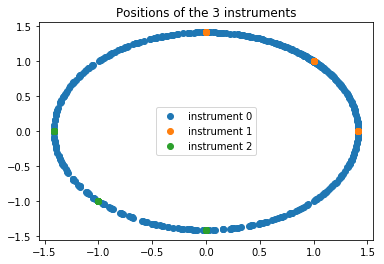

In [0]:
#Plot the trajectories of the 3 instruments

for k in range(K):
    c = (1 + 1j)*np.exp(1j*theta[k])
    plt.plot(c.real,c.imag, 'o', label = 'instrument ' + str(k))
    plt.legend()
    plt.title('Positions of the 3 instruments')

In [0]:
## Do inverse imdct
y0_new, y1_new = {}, {}
for k in range(K):
    y0_new[k], y1_new[k] = np.array(mdct.imdct(new_Y0[k])), np.array(mdct.imdct(new_Y1[k]))

In [0]:
#Listen to result

ar = x.copy()
shape1,_= x.shape
for xx in range(shape1):
    ar[xx,0] = sum([y0_new[k][xx] for k in range(K)])
    ar[xx,1] = sum([y1_new[k][xx] for k in range(K)])
    

Instruments = ['piano','guitar','double bass']

write('mmse.wav',Fs,ar)
play_music('mmse.wav')